# **First** autoencoder

## Importing data

In [15]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

#from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

In [16]:
bigData = pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

In [17]:
true_phases=pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/true_phi.txt",sep=" ")

In [18]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

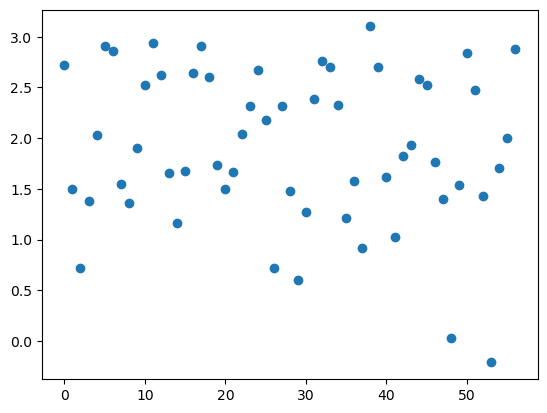

In [19]:
plt.plot(DATA[1,:], 'o')

## PCA

In [20]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [21]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  -2.7755575615628914e-17


In [22]:
pca_points=pca.fit_transform(Et)

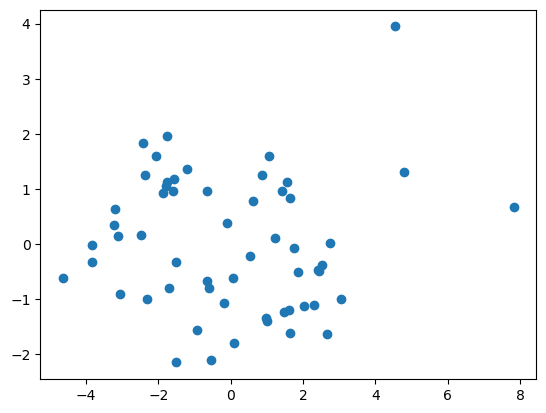

In [23]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [24]:
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])

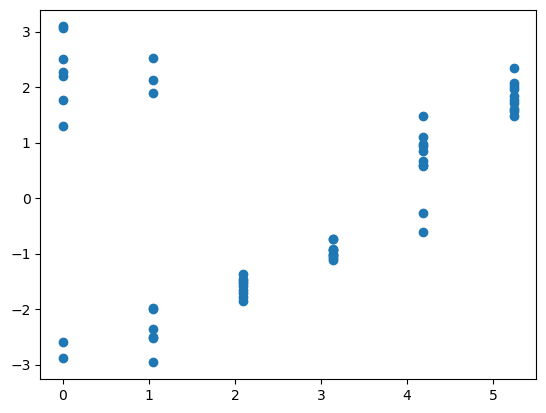

In [25]:
plt.plot(true_phases,PCA_phi, 'o')

## Torch Linear

### Setting the network

In [26]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()

In [27]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [28]:
model = LinearEncoder()
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [29]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [30]:
#recon= reconstruction of the input
num_epochs=600
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 30 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 9.125815391540527
epoch  30 Loss 0.4364248216152191
epoch  60 Loss 0.4199622571468353
epoch  90 Loss 0.3571462631225586
epoch  120 Loss 0.19812895357608795
epoch  150 Loss 0.07516071200370789
epoch  180 Loss 0.055325698107481
epoch  210 Loss 0.051441092044115067
epoch  240 Loss 0.05030073598027229
epoch  270 Loss 0.04987481236457825
epoch  300 Loss 0.04975997284054756
epoch  330 Loss 0.04973706603050232
epoch  360 Loss 0.04974629357457161
epoch  390 Loss 0.049767788499593735
epoch  420 Loss 0.04979350045323372
epoch  450 Loss 0.04982032999396324
epoch  480 Loss 0.049847543239593506
epoch  510 Loss 0.049874067306518555
epoch  540 Loss 0.049900252372026443
epoch  570 Loss 0.049925655126571655


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [31]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [32]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(0.1206, grad_fn=<DotBackward0>)

In [33]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

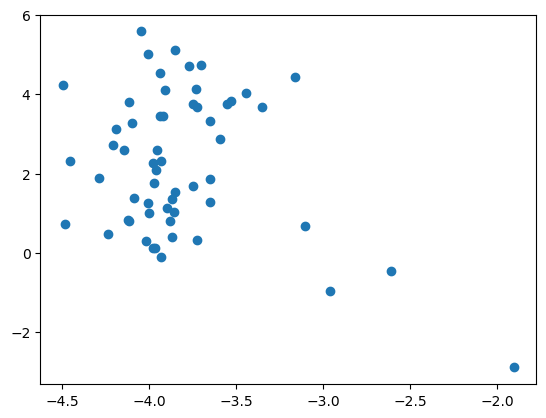

In [34]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [35]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )

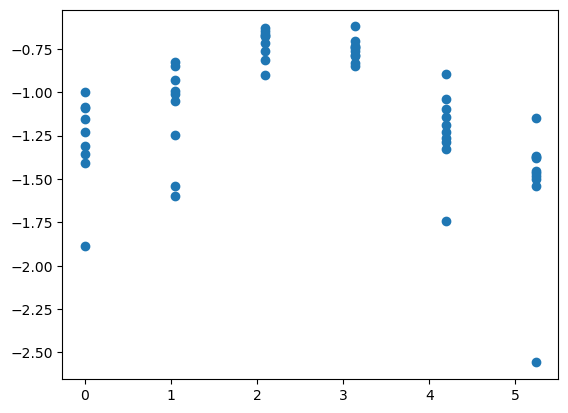

In [36]:
plt.plot(true_phases,inf_phases,'o')

## Adding the "circular" activation function

### Setting the network

In [37]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [54]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [55]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [57]:
#recon= reconstruction of the input
num_epochs=100
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 1 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.170764446258545
epoch  1 Loss 5.938480377197266
epoch  2 Loss 5.7284932136535645
epoch  3 Loss 5.532712459564209
epoch  4 Loss 5.34698486328125
epoch  5 Loss 5.168949604034424
epoch  6 Loss 4.996892929077148
epoch  7 Loss 4.829432964324951
epoch  8 Loss 4.66546630859375
epoch  9 Loss 4.5043416023254395
epoch  10 Loss 4.345902919769287
epoch  11 Loss 4.190212726593018
epoch  12 Loss 4.037322521209717
epoch  13 Loss 3.8873510360717773
epoch  14 Loss 3.740529775619507
epoch  15 Loss 3.597163438796997
epoch  16 Loss 3.4575812816619873
epoch  17 Loss 3.3220977783203125
epoch  18 Loss 3.1909847259521484
epoch  19 Loss 3.064455986022949
epoch  20 Loss 2.9426660537719727
epoch  21 Loss 2.8256969451904297
epoch  22 Loss 2.7135705947875977
epoch  23 Loss 2.6062448024749756
epoch  24 Loss 2.5036089420318604
epoch  25 Loss 2.405458688735962
epoch  26 Loss 2.311464548110962
epoch  27 Loss 2.2211034297943115
epoch  28 Loss 2.1344993114471436
epoch  29 Loss 2.052493095397949
epoch  30

In [59]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[ 0.1089, -0.0772, -0.1308, -0.3541, -0.0730, -0.0296,  0.0866, -0.2509,
         -0.1710, -0.1160, -0.3664,  0.2235],
        [ 0.2892,  0.2032,  0.1897,  0.0532,  0.2729,  0.1633, -0.0587, -0.3194,
          0.1034, -0.0880, -0.0110,  0.4545]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [67]:
NNphasesC=np.zeros((N_Samples,2))
print(DATA[:,0])

temp=torch.matmul(circ_encoder_base, DATA[:,0]).detach().numpy()
print(temp)

temp /= np.linalg.norm(temp)
print(temp)

np.linalg.norm( temp)


tensor([ 1.7769,  2.7178,  3.2389,  4.0250,  2.7864,  1.5765, -2.2893, -1.1756,
         1.6560,  0.5669,  3.4082,  2.0304])
[-2.2122765  0.9424745]
[-0.9199927  0.3919355]


1.0

In [85]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


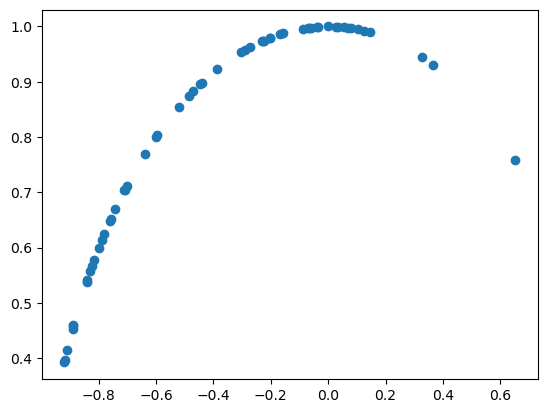

In [89]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [93]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

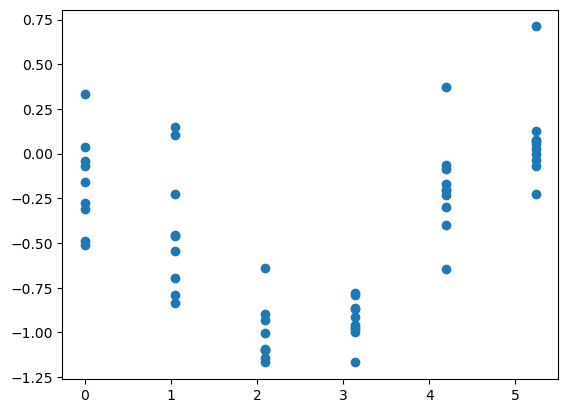

In [94]:
plt.plot(true_phases,inf_phasesC,'o')